Imports and Config

In [7]:
# Cell 1: imports & config
%matplotlib inline
import numpy as np, os, math, time
import matplotlib.pyplot as plt
from collections import deque
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib   # to save model
# Repro
RND = 42
np.random.seed(RND)

# Core config (match earlier notebook)
N_SUBC = 30
FS = 100
DURATION = 6.0   # seconds per demo sequence
WINDOW = 0.5
window_len = int(FS * WINDOW)
SEQ_LEN_SEC = 6
SEQ_T = int(FS * SEQ_LEN_SEC)

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

print("window_len:", window_len, "SEQ_T:", SEQ_T)



window_len: 50 SEQ_T: 600


Helper functions: CSI generator, buffer, features

In [ ]:
# Cell 2: helpers (self-contained copies)
def generate_csi_sample_labeled(t_index, label, n_subc=N_SUBC):
    """
    label 0 = static
    label 1 = motion
    We increase separability by:
    - Smaller Doppler + lower noise for static
    - Higher Doppler + more multipath + higher noise for motion
    """
    if label == 0:
        moving_speed = 0.01        # extremely low Doppler
        extra_noise = 0.01
        n_paths = 2
        amp_scale = 0.4
    else:
        moving_speed = 1.2         # strong Doppler
        extra_noise = 0.05
        n_paths = 5
        amp_scale = 1.0

    freqs = np.linspace(-0.5, 0.5, n_subc)
    csi = np.zeros(n_subc, dtype=np.complex128)

    for p in range(n_paths):
        amp = amp_scale * (0.5 + 0.5 * np.random.rand())
        delay = np.random.uniform(0.0, 1.0)
        doppler = moving_speed * (0.3 + 0.7 * np.random.rand())
        phase = 2 * np.pi * (doppler * (t_index/FS)) + 2*np.pi*np.random.rand()
        freq_phase = np.exp(-2j*np.pi*delay*freqs)
        csi += amp * freq_phase * np.exp(1j * phase)

    csi += (np.random.randn(n_subc) + 1j*np.random.randn(n_subc)) * extra_noise
    return csi


class CircularCSI:
    def __init__(self, maxlen):
        self.q = deque(maxlen=maxlen)
    def push(self, sample):
        self.q.append(sample)
    def get_matrix(self):
        if not self.q: return np.zeros((0, N_SUBC), dtype=np.complex128)
        return np.vstack(self.q)

def extract_features(csi_matrix):
    if csi_matrix.shape[0] == 0:
        return None
    
    amps = np.abs(csi_matrix)
    phases = np.angle(csi_matrix)
    phases_unwrapped = np.unwrap(phases, axis=0)

    amp_mean = np.mean(amps)
    amp_std = np.std(amps)
    energy = np.sum(amps ** 2)
    sub_std_mean = np.mean(np.std(amps, axis=0))

    # Doppler-like measure: mean absolute phase change
    phase_diff = np.mean(np.abs(np.diff(phases_unwrapped, axis=0)))

    # amplitude delta between start and end of window
    amp_delta = np.mean(amps[-1] - amps[0])

    return np.array([amp_mean, amp_std, energy, sub_std_mean, phase_diff, amp_delta])




Dataset generation (train/test)

In [13]:
# Cell 3: generate dataset (smaller numbers for speed)
from tqdm import tqdm   # plain tqdm works in VS Code notebooks without ipywidgets

N_SEQS_PER_CLASS = 20  # reduce to finish within time
all_feats = []
all_labels = []
meta = []

def generate_labeled_sequence(seq_id, label, seq_len=SEQ_T):
    csi_seq = np.zeros((seq_len, N_SUBC), dtype=np.complex128)
    for t in range(seq_len):
        csi_seq[t] = generate_csi_sample_labeled(t, label)
    cb = CircularCSI(window_len)
    feats = []
    labels_window = []
    for t in range(seq_len):
        cb.push(csi_seq[t])
        if t >= window_len - 1:
            feats.append(extract_features(cb.get_matrix()))
            labels_window.append(label)
    return csi_seq, np.array(feats), np.array(labels_window)

for label in [0,1]:
    for i in tqdm(range(N_SEQS_PER_CLASS), desc=f"Gen label {label}"):
        seq_id = f"{label}_{i}"
        _, feats, labels_window = generate_labeled_sequence(seq_id, label)
        all_feats.append(feats)
        all_labels.append(labels_window)
        meta.append(seq_id)

# flatten windows
X = np.vstack(all_feats)
y = np.concatenate(all_labels)
print("Flat dataset X,y:", X.shape, y.shape)

# train/test split by sequence to avoid leakage
seq_indices = np.arange(len(meta))
label_per_seq = np.array([int(m.split("_")[0]) for m in meta])
train_idx, test_idx = train_test_split(seq_indices, test_size=0.25, random_state=RND, stratify=label_per_seq)

def build_split(idx_list):
    Xs, ys = [], []
    for idx in idx_list:
        Xs.append(all_feats[idx])
        ys.append(all_labels[idx])
    return np.vstack(Xs), np.concatenate(ys)

X_train, y_train = build_split(train_idx)
X_test, y_test = build_split(test_idx)
print("Train shape:", X_train.shape, y_train.shape, "Test shape:", X_test.shape, y_test.shape)

# save
np.savez_compressed(os.path.join(DATA_DIR, "csi_windows_small.npz"),
                    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, meta=meta)
print("Saved dataset to", os.path.join(DATA_DIR, "csi_windows_small.npz"))




Gen label 1: 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]

Flat dataset X,y: (22040, 6) (22040,)
Train shape: (16530, 6) (16530,) Test shape: (5510, 6) (5510,)
Saved dataset to data/csi_windows_small.npz


Train Random Forest & show metrics

In [15]:
# Cell 4: train RF
# quick scaling not required for RF, but shuffle
perm = np.random.permutation(len(X_train))
Xtr, ytr = X_train[perm], y_train[perm]

rf = RandomForestClassifier(n_estimators=100, random_state=RND, n_jobs=-1)
rf.fit(Xtr, ytr)
# eval
y_pred_train = rf.predict(Xtr)
y_pred_test = rf.predict(X_test)
print("Train acc:", accuracy_score(ytr, y_pred_train))
print("Test acc:", accuracy_score(y_test, y_pred_test))
print("\nClassification report (test):\n", classification_report(y_test, y_pred_test))
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_pred_test))

# save model
model_path = os.path.join(DATA_DIR, "rf_csi_model.joblib")
joblib.dump(rf, model_path)
print("Saved RF model to", model_path)



Train acc: 1.0
Test acc: 1.0

Classification report (test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2755
           1       1.00      1.00      1.00      2755

    accuracy                           1.00      5510
   macro avg       1.00      1.00      1.00      5510
weighted avg       1.00      1.00      1.00      5510

Confusion matrix (test):
 [[2755    0]
 [   0 2755]]
Saved RF model to data/rf_csi_model.joblib


StreamProcessor (streaming DS&A + online classifier wrapper)

In [16]:
# Cell 5: StreamProcessor (streaming DS&A)
class StreamProcessor:
    def __init__(self, window_len, n_subc=N_SUBC, topk=3, clf=None):
        self.window_len = window_len
        self.n_subc = n_subc
        self.cb = deque(maxlen=window_len)
        self.median_deques = [deque(maxlen=window_len) for _ in range(n_subc)]
        self.topk = topk
        self.feat_history = []
        self.clf = clf

    def push(self, csi_sample):
        self.cb.append(csi_sample)
        for sc in range(self.n_subc):
            self.median_deques[sc].append(np.abs(csi_sample[sc]))

    def has_window(self):
        return len(self.cb) == self.window_len

    def window_matrix(self):
        return np.vstack(self.cb) if self.cb else np.zeros((0,self.n_subc))

    def window_features(self):
        mat = self.window_matrix()
        return extract_features(mat) if mat.shape[0]>0 else None

    def anomaly_zscore(self, z_thresh=3.0, hist_len=50):
        feat = self.window_features()
        if feat is None: return False, 0.0
        amp_mean = feat[0]
        self.feat_history.append(amp_mean)
        if len(self.feat_history) < hist_len:
            return False, 0.0
        hist = np.array(self.feat_history[-hist_len:])
        mu, sigma = hist.mean(), hist.std(ddof=0)
        if sigma == 0: return False, 0.0
        z = (amp_mean - mu) / sigma
        return abs(z) > z_thresh, z

    def topk_subcarriers(self):
        mat = self.window_matrix()
        if mat.shape[0] == 0: return [], np.zeros(self.n_subc)
        amps = np.abs(mat)
        sub_energy = amps.sum(axis=0)
        topk_idx = np.argsort(sub_energy)[-self.topk:][::-1]
        return topk_idx, sub_energy

    def moving_median(self):
        return np.array([np.median(d) if len(d)>0 else 0.0 for d in self.median_deques])

    def predict_online(self):
        feat = self.window_features()
        if feat is None or self.clf is None: return None
        return self.clf.predict(feat.reshape(1,-1))[0]



Streaming demo: mixed sequence, plot classifier + anomaly

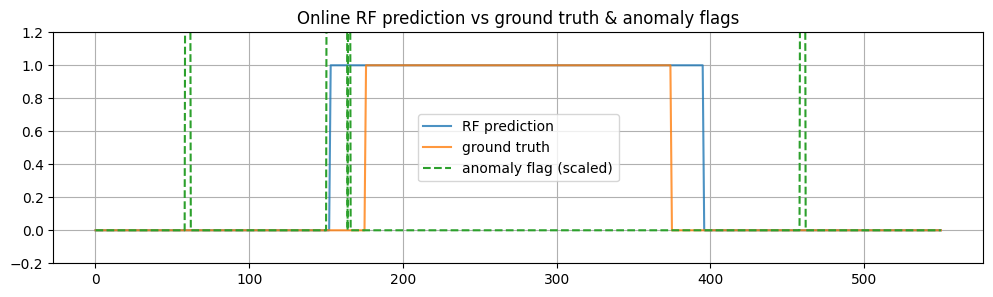

Online classifier acc: 0.9201451905626135
Confusion matrix:
 [[308  44]
 [  0 199]]


In [17]:
# Cell 6: streaming demo and plotting
# create mixed sequence: static(2s) -> motion(2s) -> static(2s)
demo_static, _, _ = generate_labeled_sequence("demo0", label=0, seq_len=SEQ_T)
demo_motion, _, _ = generate_labeled_sequence("demo1", label=1, seq_len=SEQ_T)
mixed_seq = np.vstack([demo_static[:2*FS], demo_motion[:2*FS], demo_static[:2*FS]])
# ground truth per-window
gt_windows = []
cbtmp = deque(maxlen=window_len)
for t in range(mixed_seq.shape[0]):
    # label timeline: 0 for first 2s, 1 for next 2s, 0 last 2s
    lab = 1 if (t >= 2*FS and t < 4*FS) else 0
    cbtmp.append(lab)
    if len(cbtmp) == window_len:
        gt_windows.append(1 if np.mean(cbtmp)>0.5 else 0)
gt_windows = np.array(gt_windows)

proc = StreamProcessor(window_len=window_len, n_subc=N_SUBC, topk=4, clf=rf)
zscores, anoms, preds = [], [], []

for t in range(mixed_seq.shape[0]):
    proc.push(mixed_seq[t])
    if proc.has_window():
        is_anom, z = proc.anomaly_zscore(z_thresh=3.0, hist_len=50)
        pred = proc.predict_online()
        zscores.append(z); anoms.append(1 if is_anom else 0); preds.append(pred)

zscores = np.array(zscores)
anoms = np.array(anoms)
preds = np.array(preds)
# plot classifier predictions vs ground truth
plt.figure(figsize=(12,3))
plt.plot(preds, label="RF prediction", alpha=0.8)
plt.plot(gt_windows, label="ground truth", alpha=0.8)
plt.plot(anoms * np.max(zscores), '--', label="anomaly flag (scaled)")
plt.ylim(-0.2, 1.2)
plt.legend(); plt.title("Online RF prediction vs ground truth & anomaly flags"); plt.grid(True)
plt.show()

# metrics
valid_idx = ~np.isnan(preds)
print("Online classifier acc:", accuracy_score(gt_windows[valid_idx], preds[valid_idx]))
print("Confusion matrix:\n", confusion_matrix(gt_windows[valid_idx], preds[valid_idx]))
